In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.express as px

warnings.filterwarnings('ignore')

def analyze_and_visualize_features(file_path):
    """
    Analyze features with comprehensive visualizations including correlation heatmaps
    """
    # Read data
    df = pd.read_csv(file_path, parse_dates=['Open time'])
    df.set_index('Open time', inplace=True)
    
    # Calculate correlation matrices
    pearson_corr = df.corr(method='pearson')
    spearman_corr = df.corr(method='spearman')
    
    # Figure 1: Correlation Heatmaps (2x1 grid)
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    # Pearson Correlation Heatmap
    sns.heatmap(pearson_corr, 
                annot=False, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                ax=ax1)
    ax1.set_title('Pearson Correlation Heatmap', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Spearman Correlation Heatmap
    sns.heatmap(spearman_corr, 
                annot=False, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                ax=ax2)
    ax2.set_title('Spearman Correlation Heatmap', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Figure 2: Feature vs Target Correlations
    features = df.drop('target', axis=1)
    target = df['target']
    
    # Calculate correlations with target
    feature_correlations = pd.DataFrame({
        'feature': features.columns,
        'pearson_corr': [pearson_corr.loc['target', col] for col in features.columns],
        'spearman_corr': [spearman_corr.loc['target', col] for col in features.columns],
        'abs_pearson': [abs(pearson_corr.loc['target', col]) for col in features.columns],
        'abs_spearman': [abs(spearman_corr.loc['target', col]) for col in features.columns]
    })
    
    # Sort by absolute Spearman correlation
    feature_correlations = feature_correlations.sort_values('abs_spearman', ascending=False)
    
    # Create visualization of top features vs target correlations
    fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 15))
    
    # Top 20 Features by Pearson Correlation
    sns.barplot(data=feature_correlations.head(20), 
                x='pearson_corr', 
                y='feature',
                palette='RdBu_r',
                ax=ax3)
    ax3.set_title('Top 20 Features by Pearson Correlation with Target', fontsize=12)
    ax3.set_xlabel('Pearson Correlation')
    
    # Top 20 Features by Spearman Correlation
    sns.barplot(data=feature_correlations.head(20), 
                x='spearman_corr', 
                y='feature',
                palette='RdBu_r',
                ax=ax4)
    ax4.set_title('Top 20 Features by Spearman Correlation with Target', fontsize=12)
    ax4.set_xlabel('Spearman Correlation')
    
    plt.tight_layout()
    
    # Figure 3: Top Features Scatter Plots
    fig3 = plt.figure(figsize=(20, 10))
    top_6_features = feature_correlations.head(6)['feature'].tolist()
    
    for i, feature in enumerate(top_6_features, 1):
        plt.subplot(2, 3, i)
        plt.scatter(features[feature], target, alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Target')
        plt.title(f'Target vs {feature}\nSpearman Corr: {spearman_corr.loc["target", feature]:.3f}')
        
        # Add trend line
        z = np.polyfit(features[feature], target, 1)
        p = np.poly1d(z)
        plt.plot(features[feature], p(features[feature]), "r--", alpha=0.8)
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\n=== Feature Analysis Summary ===")
    print(f"Total features analyzed: {len(features.columns)}")
    
    print("\nTop 10 Features by Spearman Correlation with Target:")
    summary = feature_correlations.head(10)[['feature', 'spearman_corr', 'pearson_corr']]
    print(summary.to_string(index=False))
    
    # Find features with strong correlations with target
    strong_correlations = feature_correlations[
        (feature_correlations['abs_spearman'] > 0.3) |
        (feature_correlations['abs_pearson'] > 0.3)
    ]
    
    print(f"\nFeatures with strong correlation (|correlation| > 0.3): {len(strong_correlations)}")
    
    # Identify highly correlated feature pairs among top features
    top_features = feature_correlations.head(15)['feature'].tolist()
    print("\nHighly Correlated Feature Pairs among top 15 (|correlation| > 0.8):")
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            pearson = pearson_corr.loc[top_features[i], top_features[j]]
            spearman = spearman_corr.loc[top_features[i], top_features[j]]
            if abs(pearson) > 0.8 or abs(spearman) > 0.8:
                print(f"{top_features[i]} <-> {top_features[j]}:")
                print(f"  Pearson: {pearson:.3f}")
                print(f"  Spearman: {spearman:.3f}")

    return {
        'feature_correlations': feature_correlations,
        'pearson_corr': pearson_corr,
        'spearman_corr': spearman_corr,
        'strong_correlations': strong_correlations,
        'top_features': top_features
    }

In [19]:
def granger_causality_test(file_path):
    # Read data
    df = pd.read_csv(file_path, parse_dates=['Open time'])
    df.set_index('Open time', inplace=True)
    # Assuming features_df has a datetime index and columns for each feature + 'target'

    # Parameters
    max_lag = 5  # Define the maximum lag to test for causality

    # Results dictionary to store causality test results for each feature
    causality_results = {}

    # Run Granger causality tests for each feature against the target
    for feature in df.columns.drop('target'):
        try:
            # Run Granger causality test
            test_result = grangercausalitytests(
                df[['target', feature]], max_lag, verbose=False
            )
            causality_results[feature] = {
                lag: round(result[0]['ssr_ftest'][1], 4)  # Extract p-value for each lag
                for lag, result in test_result.items()
            }
        except Exception as e:
            print(f"Error testing {feature}: {e}")

    # Display results
    causality_df = pd.DataFrame(causality_results)
    print("Granger Causality Test Results (p-values):")
    print(causality_df)
    # Assuming causality_results is populated from the previous Granger causality tests
    # Convert causality_results dictionary to a DataFrame for plotting
    causality_df = pd.DataFrame(causality_results).T  # Transpose to have features as rows

    # Create a heatmap using Plotly
    fig = px.imshow(
        causality_df,
        labels=dict(x="Lag", y="Feature", color="p-value"),
        x=causality_df.columns,  # Lags
        y=causality_df.index,     # Features
        color_continuous_scale="Viridis",
        aspect="auto",
    )

    # Customize the layout
    fig.update_layout(
        title="Granger Causality Test p-values (Feature vs Target)",
        xaxis_title="Lag",
        yaxis_title="Feature",
        coloraxis_colorbar=dict(
            title="p-value",
            tickvals=[0.01, 0.05, 0.1],
            ticktext=["0.01", "0.05", "0.1"]
        )
    )

    fig.show()


=== Feature Analysis Summary ===
Total features analyzed: 24

Top 10 Features by Spearman Correlation with Target:
         feature  spearman_corr  pearson_corr
price_ma_20_dist       0.536959      0.797856
     ma_10_slope       0.521201      0.728466
   ma_5_20_cross       0.509402      0.682614
   ma_5_10_cross       0.470635      0.687304
     ma_momentum       0.470635      0.688815
price_ma_10_dist       0.448641      0.745115
      ma_5_slope       0.434830      0.682870
      returns_20       0.430319      0.551454
     ma_20_slope       0.406235      0.481611
price_ma_50_dist       0.391256      0.563801

Features with strong correlation (|correlation| > 0.3): 13

Highly Correlated Feature Pairs among top 15 (|correlation| > 0.8):
price_ma_20_dist <-> ma_10_slope:
  Pearson: 0.882
  Spearman: 0.841
price_ma_20_dist <-> ma_5_20_cross:
  Pearson: 0.893
  Spearman: 0.873
price_ma_20_dist <-> price_ma_10_dist:
  Pearson: 0.856
  Spearman: 0.812
price_ma_20_dist <-> returns_20:
  

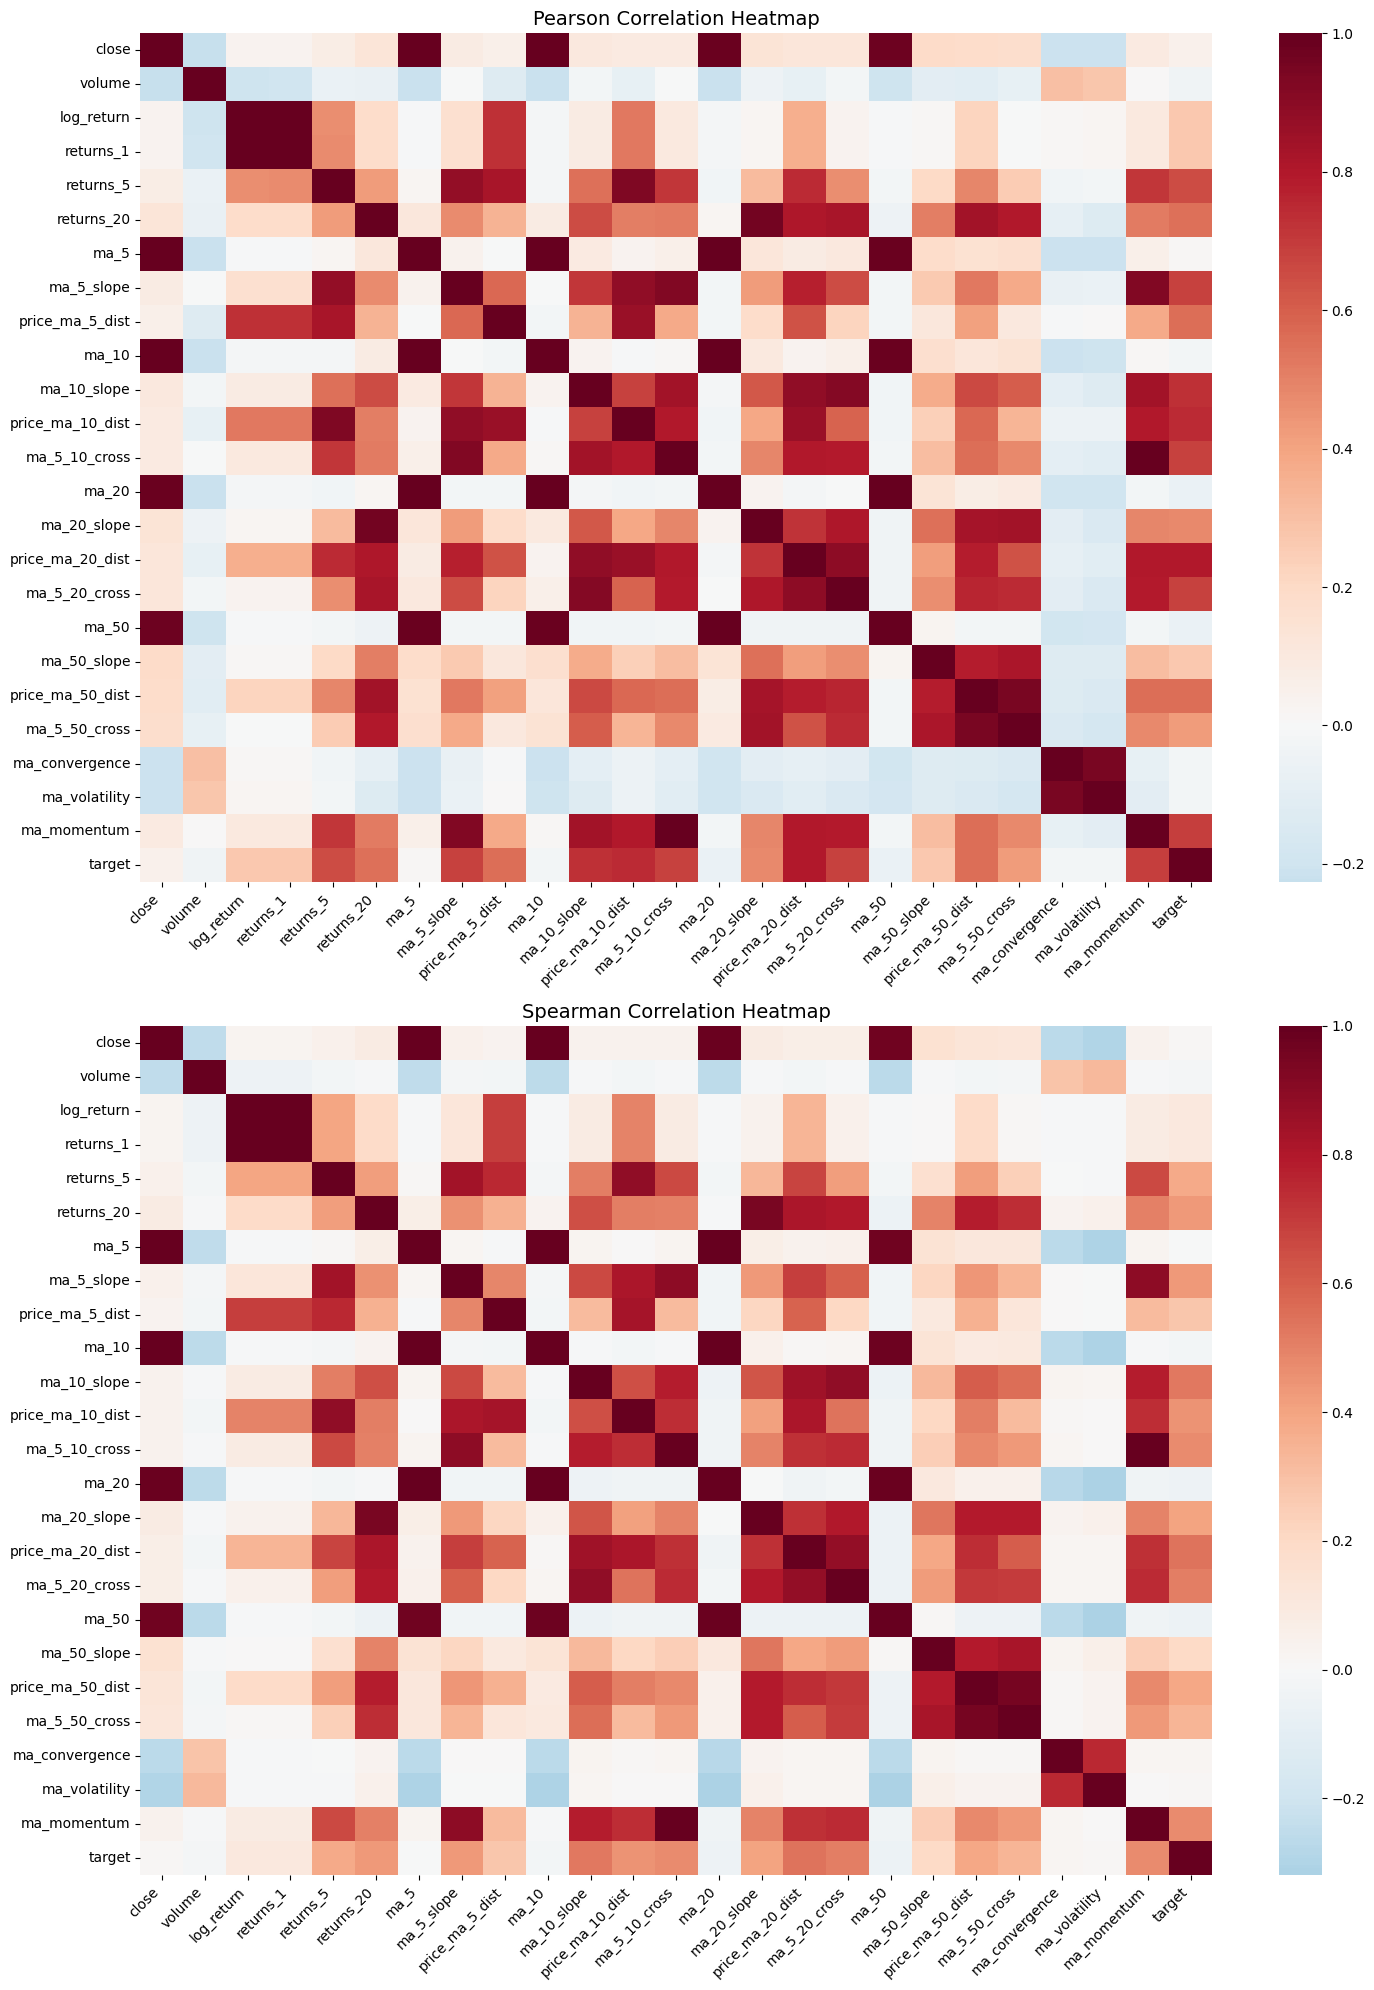

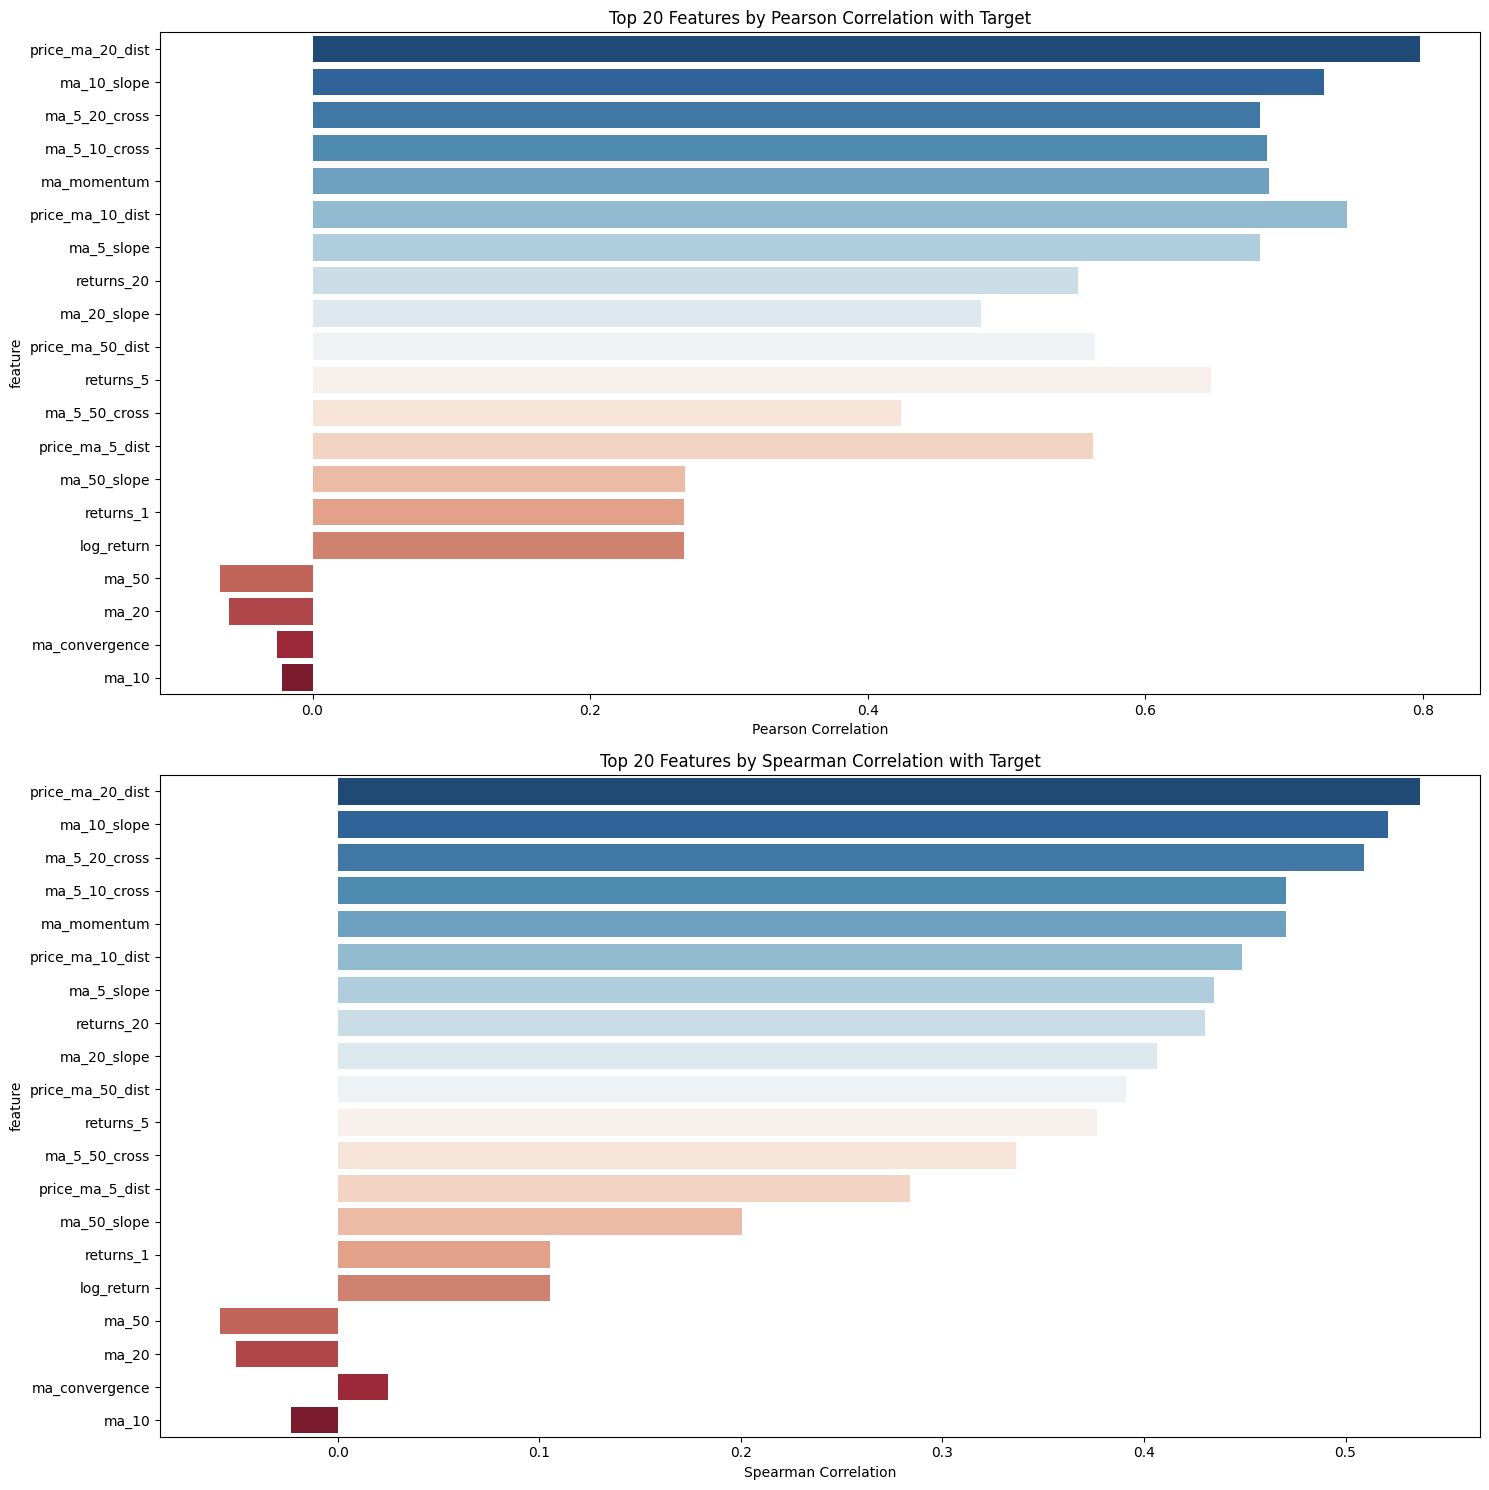

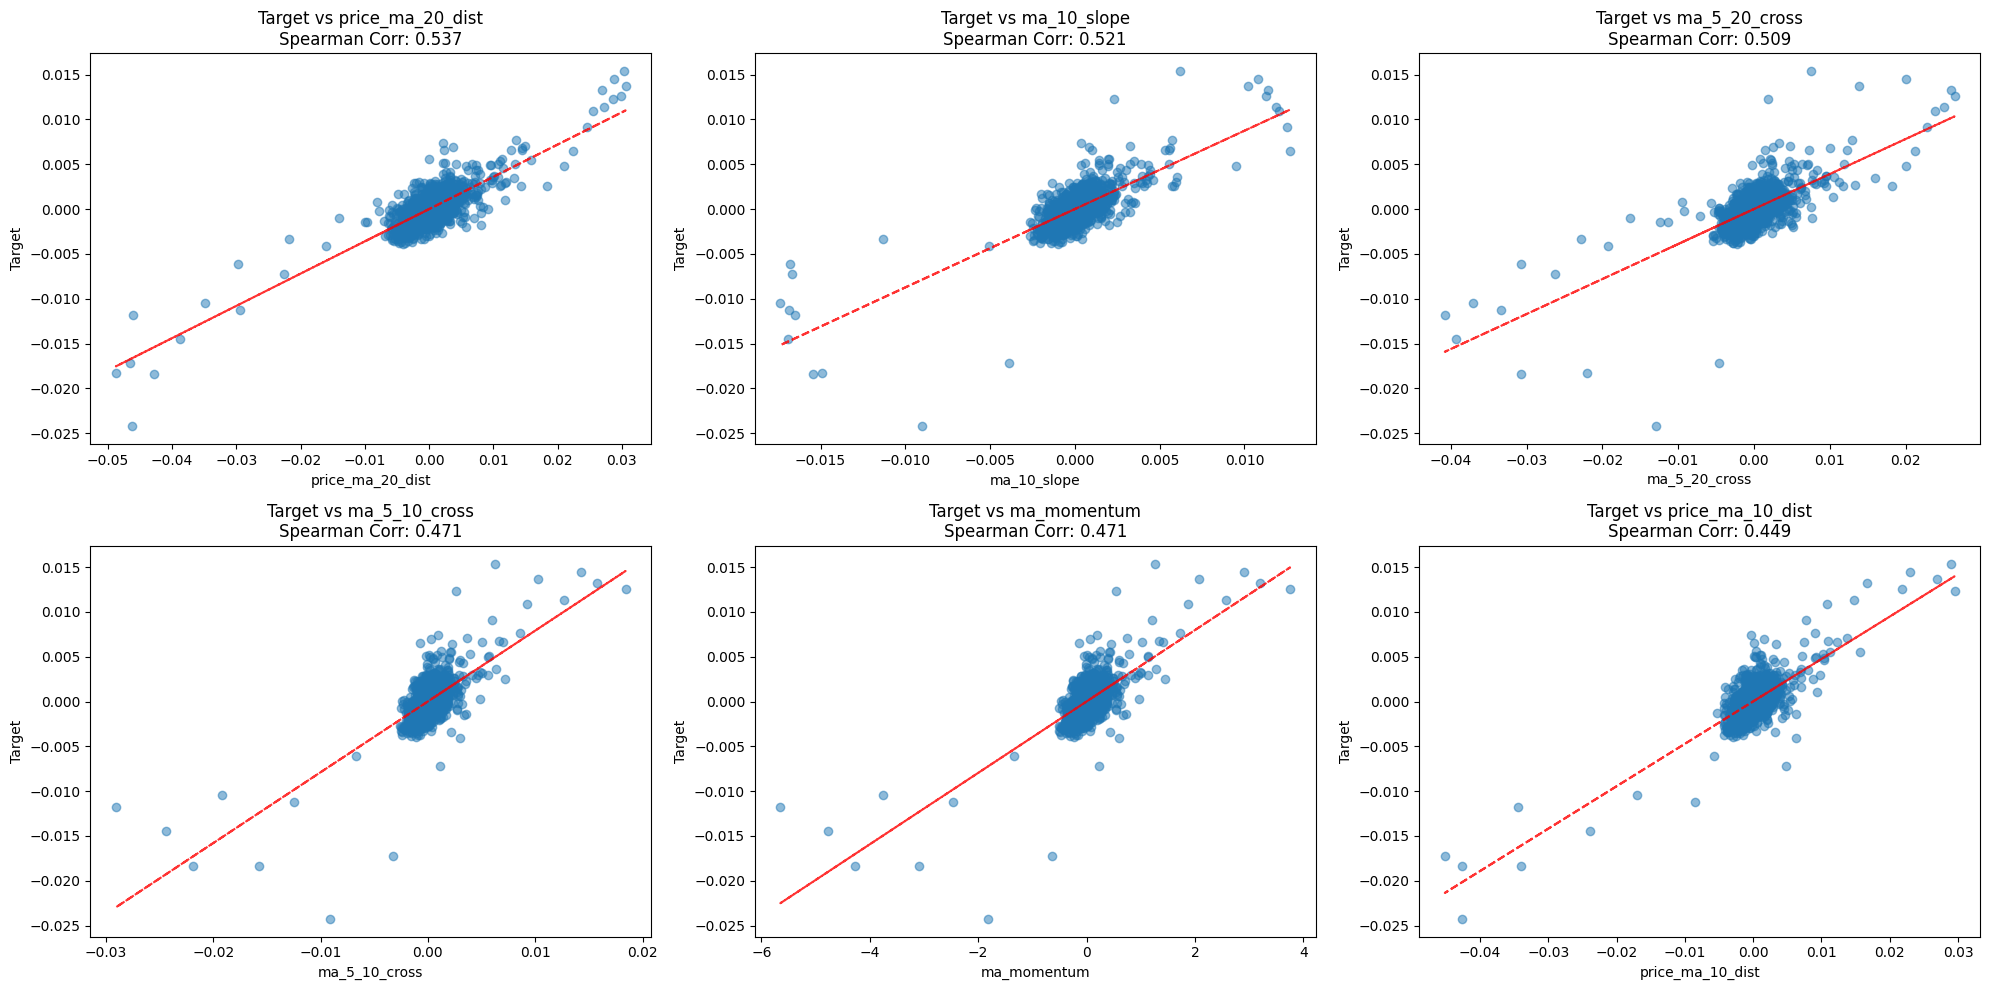

In [21]:
CSV_FILE = "features_dataset_v1.csv"  # Your data file
results = analyze_and_visualize_features(CSV_FILE)
granger_causality_test(CSV_FILE)

# Access detailed results if needed
correlations = results['feature_correlations']
pearson_matrix = results['pearson_corr']
spearman_matrix = results['spearman_corr']
strong_corr = results['strong_correlations']
top_features = results['top_features']